This notebook produces the following figures that are used in the manuscript:

1. Visual convergence of the solution of $\text{KdVH}(\tau)$ to the KdV solution using a time-stepping method.
2. Traveling Waves Using the Petviashvili Method.
3. Quantitative comparison of the asymptotic-preserving (AP) property by different time-stepping methods.
4. Asymptotic Accuracy Plots.
5. Error growth plots for different methods, with and without RK relaxation, applied to $\text{KdVH}(\tau)$, with the exact solution computed using the Petviashvili method.
6. RK relaxation on $\text{KdVH}(\tau)$ to verify linear and quadratic error convergence using conservative versus non-conservative methods.

In [1]:
include("code.jl")

  Activating project at `~/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh_RR`


plot_kdvh_traveling_approximation (generic function with 1 method)

In [2]:
using CairoMakie
set_theme!(theme_latexfonts();
           fontsize = 20,
           Lines = (linewidth = 3, cycle = Cycle([:color, :linestyle], covary = true),),
           markersize = 16)

### Visual convergence of the solution of $\text{KdVH}(\tau)$ to the KdV solution.

  1.055297 seconds (3.64 M allocations: 245.686 MiB, 3.40% gc time, 84.26% compilation time)
  1.515401 seconds (3.95 M allocations: 266.646 MiB, 2.51% gc time, 78.59% compilation time)
  0.339114 seconds (36.39 k allocations: 6.610 MiB, 4.74% gc time)
  0.326081 seconds (36.39 k allocations: 6.610 MiB)


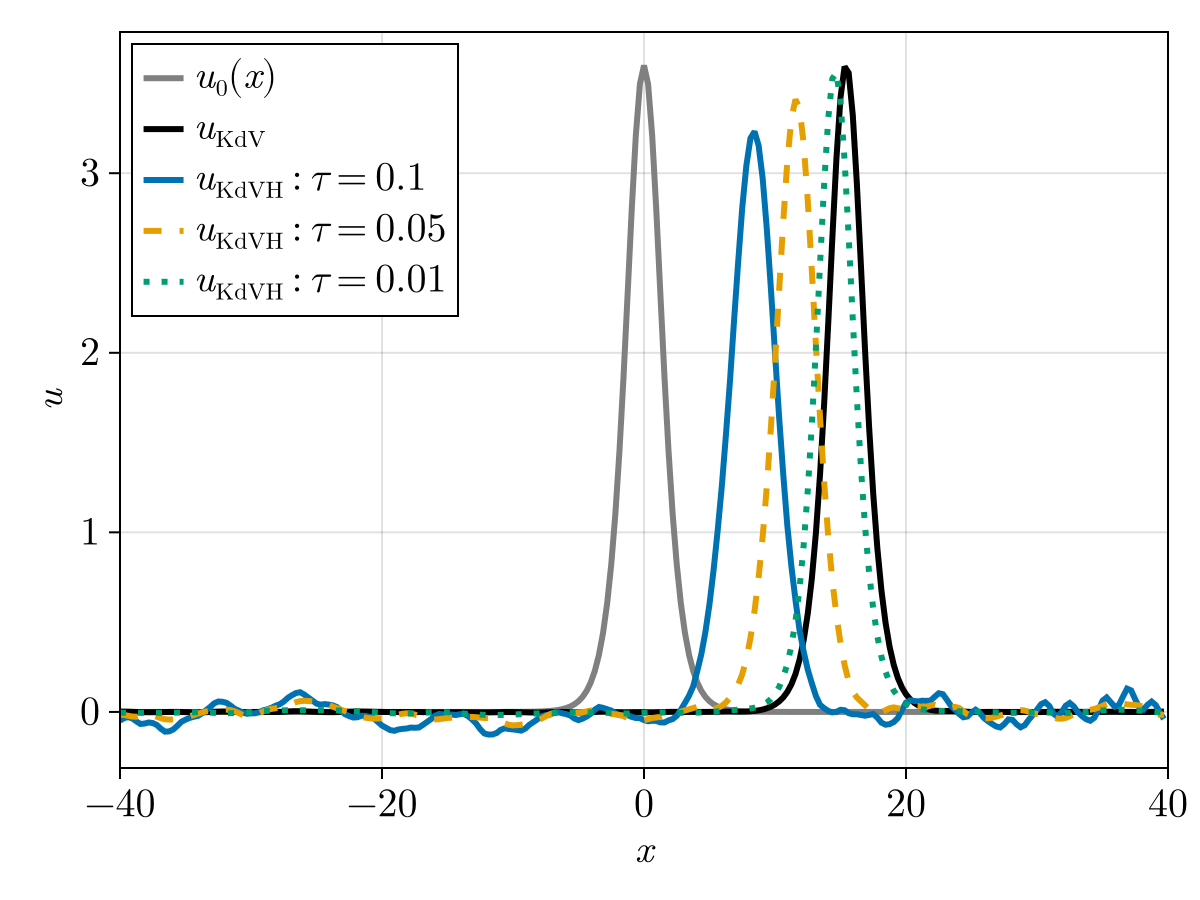

In [3]:
domain_traversals = 1.2; # This will determine the final time = domain_traversals*(xmax-xmin)/c
accuracy_order = 1; N = 2^8;
alg = ARS443(); dt = 0.01;
τs = [1.0e-1, 5.0e-2, 1.0e-2]

# Initialization of physical and numerical parameters
(; xmin, xmax, c) = solitary_wave_setup()
tspan = (0.0, domain_traversals * (xmax - xmin) / c)

D1 = upwind_operators(periodic_derivative_operator;
                      derivative_order = 1, accuracy_order,
                      xmin, xmax, N)


# Setup plot
fig_KdVH_KdV = Figure()
ax = Axis(fig_KdVH_KdV[1, 1]; xlabel = L"x", ylabel = L"u")

# KdV
let equation = KdV()
    (; q0, parameters) = setup(solitary_wave_solution, equation,
                               tspan, D1)
    @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                           rhs_nonstiff!,
                           q0, tspan, parameters, alg;
                           dt)

    x = grid(parameters.D1)
    lines!(ax, x, get_u(sol.u[begin], equation);
           label = L"u_0(x)", color = :gray)
    lines!(ax, x, get_u(sol.u[end], equation);
           label = L"u_\mathrm{KdV}", color = :black)
end

# Assuming `τs` is an array of different values of τ=
for (i, τ) in enumerate(τs)
    # HyperbolizedKdV with IMEX
    let equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt)

        x = grid(parameters.D1)
        # Use label with τ and different line styles
        lines!(ax, x, get_u(sol.u[end], equation);
               label = L"u_\mathrm{KdVH}: \tau = %$(τ)")
    end
end

axislegend(ax, position = :lt)
xlims!(ax, xmin, xmax)
fig_KdVH_KdV

In [4]:
# Define paths
save_path_1 = joinpath(@__DIR__, "img")
save_path_2 = joinpath(@__DIR__, "tables_data")

# Create directories if they do not exist
if !isdir(save_path_1)
    mkdir(save_path_1)
end

if !isdir(save_path_2)
    mkdir(save_path_2)
end

In [5]:
save(joinpath(save_path_1, "KdVH_convergence_KdV_ARS443.pdf"), fig_KdVH_KdV)

CairoMakie.Screen{PDF}


### Traveling Waves Using the Petviashvili Method.

In [6]:
# Exact solution for the traveling wave solution for the KdV
function kdv_solution(ξ, c)
    A = 3 * c
    K = sqrt(3 * A) / 6

    return A / cosh(K * ξ)^2
end

kdv_solution (generic function with 1 method)

In [7]:
function petviashvili_kdv(; xmin = - 40.0, xmax = 40.0, c = 1/3, N = 2^8, maxiter = 1000, tol = 1.0e-14)

    D = fourier_derivative_operator(xmin, xmax, N)

    L = c * I - D^2
    N_fun(u) = 0.5 .* u.^2
    γ = 2
    # Initialization
    x = grid(D)
    u0 = exp.(-x.^2)
    # Iteration
    u = copy(u0)
    for iter in 1:maxiter
        res = norm(L * u - N_fun(u), Inf)
        #println(res)
        if res < tol
            @info "Converged" iter res
            break
        end
        m = integrate(u .* (L * u), D) / integrate(u .* N_fun(u), D)
        u = m^γ * (L \ N_fun(u))
    end

    return (; x, u)
end

petviashvili_kdv (generic function with 1 method)

In [37]:
function petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = 100, c = 1/3, N = 2^8, maxiter = 1000, tol = 1.0e-14)
    # Setup numerical discretization with periodic boundary conditions

    D = fourier_derivative_operator(xmin, xmax, N)
    D1 = Matrix(D);
    L = (λ^2*c/((λ+c)*(λ-c^2))) .* I - D^2

    N_fun(u) = (λ^2/((λ+c)*(λ-c^2))) .*0.5 .* u.^2 + (c/(λ-c^2)) .* D1 * (u .* (D1 * u))
    γ = 2
    # Initialization
    x = grid(D)
    u0 = exp.(-x.^2)

    # Iteration
    u = copy(u0)
    for iter in 1:maxiter
        res = norm(L * u - N_fun(u), Inf)
        #println(res)
        if res < tol
            @info "Converged" iter=iter res=res
            break
        end
        m = integrate(u .* (L * u), D) / integrate(u .* N_fun(u), D)
        u = m^γ * (L \ N_fun(u))
    end
    return (; x, u)
end

petviashvili_kdvh (generic function with 1 method)

#### Plot

┌ Info: Converged
│   iter = 62
└   res = 6.966649479522857e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdv - u_ana, Inf) = 3.736445463143145e-10
┌ Info: Converged
│   iter = 54
└   res = 7.668487006787357e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdvh_1 - u_ana, Inf) = 0.143596533919097
┌ Info: Converged
│   iter = 58
└   res = 9.159339953157541e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdvh_2 - u_ana, Inf) = 0.07589301216250632
┌ Info: Converged
│   iter = 61
└   res = 8.548717289613705e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdvh_3 - u_ana, Inf) = 0.01593598115019218


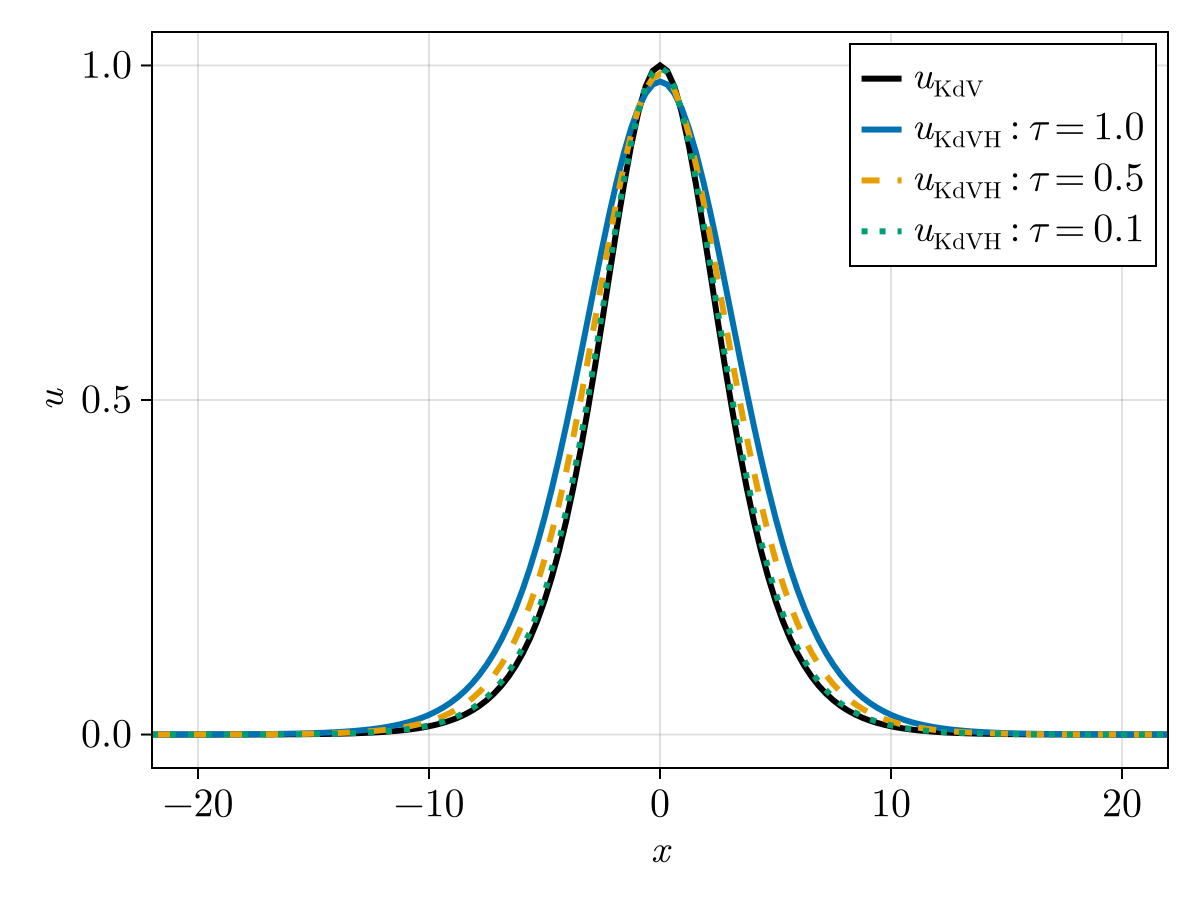

In [38]:
c = 1/3;
x, u_kdv = petviashvili_kdv(; xmin = - 40.0, xmax = 40.0, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
u_ana = kdv_solution.(x, c)

@info "Error wrt KdV solution" norm(u_kdv - u_ana, Inf)

τ1 = 1.0e-0; λ1 = 1/τ1;
x, u_kdvh_1 = petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = λ1, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
@info "Error wrt KdV solution" norm(u_kdvh_1 - u_ana, Inf)

τ2 = 5.0e-1; λ2 = 1/τ2;
x, u_kdvh_2 = petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = λ2, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
@info "Error wrt KdV solution" norm(u_kdvh_2 - u_ana, Inf)

τ3 = 1.0e-1; λ3 = 1/τ3;
x, u_kdvh_3 = petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = λ3, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
@info "Error wrt KdV solution" norm(u_kdvh_3 - u_ana, Inf)

# Visualization
xL = -7*π; xR = 7*π
fig_sol_wave = Figure()
ax = Axis(fig_sol_wave[1, 1]; xlabel = L"x", ylabel = L"u")
lines!(ax, x, u_ana; label = L"u_\mathrm{KdV}", color = :black)
lines!(ax, x, u_kdvh_1; label = L"u_\mathrm{KdVH}: \tau = %$(τ1)")
lines!(ax, x, u_kdvh_2; label = L"u_\mathrm{KdVH}: \tau = %$(τ2)")
lines!(ax, x, u_kdvh_3; label = L"u_\mathrm{KdVH}: \tau = %$(τ3)")
axislegend(ax, position = :rt)
xlims!(ax, xL, xR)
fig_sol_wave

In [39]:
save(joinpath(save_path_1, "solitary_wave_kdv_kdvh.pdf"), fig_sol_wave)

CairoMakie.Screen{PDF}


### Quantitative comparison of the asymptotic-preserving (AP) property by different time-stepping methods.

In [54]:
# Convergence in the hyperbolic relaxation parameter
function save_table_as_latex(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w, filename)
    data = hcat(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w)
    header = ["\tau", "error u", "EOC u", "error v", "EOC v", "error w", "EOC w"]  # Use LaTeX math mode for τ
    kwargs = (; header, formatters=(ft_printf("%.2e", [1, 2, 4, 6]),
                                    ft_printf("%.2f", [3, 5, 7])))

    open(filename, "w") do io
        println(io, "\\begin{table}[ht]")  # Start the table environment
        println(io, "\\centering")         # Center the table
        pretty_table(io, data; kwargs..., backend=Val(:latex))
        println(io, "\\caption{....}")  # Optional caption
        println(io, "\\end{table}")     # End the table environment
    end
end

function get_uvw(q, equations::HyperbolizedKdV)
    N = length(q) ÷ 3
    u = view(q, (0 * N + 1):(1 * N))
    v = view(q, (1 * N + 1):(2 * N))
    w = view(q, (2 * N + 1):(3 * N))
    return (; u = u,v = v, w = w)
end

function AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^8,
                            spatial_discretization = periodic_derivative_operator,
                            polydeg = 7,
                            Nx = 2^5,
                            alg = ARS443(),
                            ImEx_name = "ARS443",
                            dt = 0.005,
                            kwargs...)
    # Initialization of physical and numerical parameters
    (; xmin, xmax, c) = solitary_wave_setup()
    tspan = (0.0, domain_traversals * (xmax - xmin) / c)

    if spatial_discretization === periodic_derivative_operator
        D1 = upwind_operators(periodic_derivative_operator;
                              derivative_order = 1, accuracy_order = 8,
                              xmin, xmax, N)
    elseif spatial_discretization === LegendreDerivativeOperator
        D_local = LegendreDerivativeOperator(-1.0, 1.0, polydeg + 1)
        mesh = UniformPeriodicMesh1D(; xmin, xmax, Nx)
        D1 = PeriodicUpwindOperators(
            couple_discontinuously(D_local, mesh, Val(:minus)),
            couple_discontinuously(D_local, mesh, Val(:central)),
            couple_discontinuously(D_local, mesh, Val(:plus))
        )
    elseif spatial_discretization === fourier_derivative_operator
        D1 = fourier_derivative_operator(xmin, xmax, N)
    end


    # τs = [1.0e-1, 1.0e-2, 1.0e-3, 1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7,
    #      1.0e-8, 1.0e-9, 1.0e-10, 1.0e-11, 1.0e-12]
    τs = [1.0e-1, 1.0e-3, 1.0e-5, 1.0e-7, 1.0e-9, 1.0e-11]

    errors_u_num = Float64[]
    errors_v_num = Float64[]
    errors_w_num = Float64[]

    u_ref_num = let
        equation = KdV()
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt = dt, kwargs...)
        get_u(sol.u[end], equation)
    end

    # Computing the numerical reference solution for the auxiliary variables using the derivative operator
    v_ref_num = similar(u_ref_num)
    w_ref_num = similar(u_ref_num)
    if spatial_discretization === periodic_derivative_operator
        mul!(v_ref_num, D1.minus, u_ref_num)
        mul!(w_ref_num, D1.central, v_ref_num)
    elseif spatial_discretization === LegendreDerivativeOperator
        mul!(v_ref_num, D1.minus, u_ref_num)
        mul!(w_ref_num, D1.central, v_ref_num)
    elseif spatial_discretization === fourier_derivative_operator
        mul!(v_ref_num, D1, u_ref_num)
        mul!(w_ref_num, D1, v_ref_num)
    end

    for τ in τs
        equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt = dt, kwargs...)

        x = grid(parameters.D1)
        uvw = get_uvw(sol.u[end], equation)

        error_u = integrate(abs2, uvw.u - u_ref_num, parameters.D1) |> sqrt
        error_v = integrate(abs2, uvw.v - v_ref_num, parameters.D1) |> sqrt
        error_w = integrate(abs2, uvw.w - w_ref_num, parameters.D1) |> sqrt
        push!(errors_u_num, error_u); push!(errors_v_num, error_v); push!(errors_w_num, error_w)
    end

    let
        errors_u = errors_u_num
        errors_v = errors_v_num
        errors_w = errors_w_num
        @info "Errors with respect to the numerical KdV solution"
        eoc_u = compute_eoc(inv.(τs), errors_u)
        eoc_v = compute_eoc(inv.(τs), errors_v)
        eoc_w = compute_eoc(inv.(τs), errors_w)

        # Change the name of the file here when use different time-stepping methods
        filename = joinpath(save_path_2, ImEx_name * "_errors_num.tex")
        #filename = "Figures/" * ImEx_name * "_errors_num.tex"
        if save_latex_table
            save_table_as_latex(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w, filename)
        end

        data = hcat(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w)
        header = ["\tau", "error u", "EOC u", "error v", "EOC v", "error w", "EOC w"]  # Use LaTeX math mode for τ
        kwargs = (; header, formatters=(ft_printf("%.2e", [1, 2, 4, 6]),
                                    ft_printf("%.2f", [3, 5, 7])))
        pretty_table(data; kwargs...)
        if latex
            pretty_table(data; kwargs..., backend=Val(:latex))
        end
    end

end

AP_property_imex (generic function with 1 method)

#### AP property by type I methods.

In [11]:
# AP results by SSP2-IMEX(2,2,2)
#SSP2-IMEX(2,2,2): 2nd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - NOT SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = SSP2ImEx222(),
                   ImEx_name = "SSP2ImEx222",
                   dt = 0.005)

  0.554533 seconds (316.04 k allocations: 32.237 MiB, 31.84% compilation time)
  1.232197 seconds (2.37 M allocations: 168.893 MiB, 2.17% gc time, 56.73% compilation time)
  0.541044 seconds (22.57 k allocations: 35.404 MiB)
  2.898674 seconds (22.59 k allocations: 64.488 MiB, 0.33% gc time)
  2.977203 seconds (22.59 k allocations: 79.026 MiB, 0.21% gc time)
  2.985676 seconds (22.59 k allocations: 79.024 MiB, 0.05% gc time)
  3.020595 seconds (22.58 k allocations: 79.026 MiB)


[ Info: Errors with respect to the numerical KdV solution


┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.61e+00 │   NaN │
│ 1.00e-03 │ 5.35e-02 │  0.92 │ 4.47e-02 │  0.92 │ 5.55e-02 │  0.91 │
│ 1.00e-05 │ 5.37e-04 │  1.00 │ 8.96e-03 │  0.35 │ 1.63e-02 │  0.27 │
│ 1.00e-07 │ 5.37e-06 │  1.00 │ 9.51e-03 │ -0.01 │ 1.69e-02 │ -0.01 │
│ 1.00e-09 │ 5.39e-08 │  1.00 │ 9.52e-03 │ -0.00 │ 1.69e-02 │ -0.00 │
│ 1.00e-11 │ 7.39e-10 │  0.93 │ 9.52e-03 │ -0.00 │ 1.69e-02 │ -0.00 │
└──────────┴──────────┴───────┴──────────┴───────┴──────────┴───────┘


In [12]:
# AP results by SSP2-IMEX(3,3,2)
# SSP2-IMEX(3,3,2): 2nd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = SSP2ImEx332(),
                   ImEx_name = "SSP2ImEx332",
                   dt = 0.005)

  0.708032 seconds (187.19 k allocations: 30.055 MiB, 18.37% compilation time)
  1.134981 seconds (201.35 k allocations: 56.501 MiB, 18.13% gc time, 28.19% compilation time)
  0.819493 seconds (26.02 k allocations: 45.480 MiB)
  4.591967 seconds (26.05 k allocations: 89.108 MiB, 4.14% gc time)
  4.708498 seconds (26.05 k allocations: 118.184 MiB, 0.03% gc time)
  4.600181 seconds (26.05 k allocations: 118.180 MiB, 0.02% gc time)
  4.606503 seconds (26.05 k allocations: 118.182 MiB, 0.03% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.61e+00 │   NaN │
│ 1.00e-03 │ 5.35e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.92e-04 │  1.00 │ 6.46e-04 │  0.99 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 1.23e-05 │  0.80 │ 2.61e-05 │  0.70 │
│ 1.00e-

[ Info: Errors with respect to the numerical KdV solution


In [13]:
# AP results by AGSA(3,4,2)
# AGSA(3,4,2): 2nd order type I ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = AGSA342(),
                   ImEx_name = "AGSA342",
                   dt = 0.005)

  0.911429 seconds (191.49 k allocations: 36.896 MiB, 16.68% compilation time)
  1.187709 seconds (204.85 k allocations: 66.582 MiB, 0.54% gc time, 9.55% compilation time)
  1.113012 seconds (29.50 k allocations: 55.559 MiB)
  4.894437 seconds (29.54 k allocations: 128.263 MiB, 0.21% gc time)
  6.135017 seconds (29.54 k allocations: 157.340 MiB, 0.02% gc time)
  6.097976 seconds (29.54 k allocations: 157.340 MiB, 0.03% gc time)
  6.100193 seconds (29.54 k allocations: 157.345 MiB, 0.02% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.80e+00 │   NaN │ 3.16e+00 │   NaN │ 3.63e+00 │   NaN │
│ 1.00e-03 │ 5.93e-02 │  0.90 │ 5.44e-02 │  0.88 │ 7.12e-02 │  0.85 │
│ 1.00e-05 │ 5.94e-04 │  1.00 │ 5.50e-04 │  1.00 │ 7.32e-04 │  0.99 │
│ 1.00e-07 │ 5.94e-06 │  1.00 │ 5.49e-06 │  1.00 │ 7.30e-06 │  1.00 │
│ 1.00e-0

[ Info: Errors with respect to the numerical KdV solution


In [14]:
# AP results by SSP3-IMEX(3,4,3)
# SSP3-IMEX(3,4,3): 3rd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - NOT SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = SSP3ImEx343(),
                   ImEx_name = "SSP3ImEx343",
                   dt = 0.005)

  0.919898 seconds (190.70 k allocations: 23.384 MiB, 0.66% gc time, 15.91% compilation time)
  1.184044 seconds (204.61 k allocations: 46.625 MiB, 9.62% compilation time)
  1.091617 seconds (29.29 k allocations: 35.605 MiB)
  5.880041 seconds (29.32 k allocations: 64.689 MiB, 0.13% gc time)
  6.057219 seconds (29.30 k allocations: 79.227 MiB)
  6.005704 seconds (29.32 k allocations: 79.223 MiB, 0.07% gc time)
  5.990048 seconds (29.31 k allocations: 79.225 MiB, 0.02% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.25e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 3.73e-03 │  0.56 │ 7.22e-03 │  0.47 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 3.82e-03 │ -0.01 │ 6.80e-03 │  0.01 │
│ 1.00e-09 │ 5.38e-08 │  1.0

[ Info: Errors with respect to the numerical KdV solution


#### AP property by type II methods.

In [15]:
# AP results by ARS(2,2,2)
# ARS(2,2,2): 2nd order L-stable type II ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.
AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = ARS222(),
                   ImEx_name = "ARS222",
                   dt = 0.005)

  0.589161 seconds (183.95 k allocations: 23.250 MiB, 1.05% gc time, 23.43% compilation time)
  0.684711 seconds (197.91 k allocations: 46.472 MiB, 16.53% compilation time)
  0.582587 seconds (22.58 k allocations: 35.452 MiB)
  2.993711 seconds (22.61 k allocations: 64.537 MiB, 0.25% gc time)
  3.074875 seconds (22.61 k allocations: 79.075 MiB, 0.14% gc time)
  3.079868 seconds (22.60 k allocations: 79.072 MiB, 0.03% gc time)
  3.064816 seconds (22.60 k allocations: 79.072 MiB, 0.05% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.61e+00 │   NaN │
│ 1.00e-03 │ 5.35e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.89e-04 │  1.00 │ 6.30e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 4.89e-06 │  1.00 │ 6.30e-06 │  1.00 │
│ 1.00e-09 │

[ Info: Errors with respect to the numerical KdV solution


In [16]:
# AP results by ARS(4,4,3)
# ARS(4,4,3): 3rd order L-stable type II ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.
AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = ARS443(),
                   ImEx_name = "ARS443",
                   dt = 0.005)

  0.954673 seconds (188.84 k allocations: 23.334 MiB, 12.53% compilation time)
  1.214560 seconds (204.64 k allocations: 46.677 MiB, 9.31% compilation time)
  1.131975 seconds (29.33 k allocations: 35.658 MiB, 0.62% gc time)
  6.024405 seconds (29.32 k allocations: 64.739 MiB)
  6.030915 seconds (29.34 k allocations: 79.280 MiB, 0.11% gc time)
  6.005684 seconds (29.34 k allocations: 79.275 MiB, 0.02% gc time)
  6.078498 seconds (29.34 k allocations: 79.275 MiB, 0.02% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.76e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.89e-04 │  1.00 │ 6.31e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 4.89e-06 │  1.00 │ 6.31e-06 │  1.00 │
│ 1.00e-09 │ 5.38e-08 │  1.0

[ Info: Errors with respect to the numerical KdV solution


In [17]:
# AP results by ARS(4,4,3)
# ARS(4,4,3): 3rd order L-stable type II ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.
AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = LegendreDerivativeOperator,
                   polydeg = 3,
                   Nx = 2^8,
                   alg = ARS443(),
                   ImEx_name = "ARS443_DG",
                   dt = 0.005)

  0.775776 seconds (147.00 k allocations: 11.653 MiB)
  1.421769 seconds (108.27 k allocations: 28.217 MiB, 1.68% gc time)
  1.401984 seconds (108.26 k allocations: 28.217 MiB)
  1.400609 seconds (108.26 k allocations: 28.217 MiB)
  1.398543 seconds (108.26 k allocations: 28.217 MiB)
  1.408036 seconds (108.26 k allocations: 28.217 MiB)
  1.422082 seconds (108.29 k allocations: 28.218 MiB, 1.10% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.76e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.89e-04 │  1.00 │ 6.31e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 4.89e-06 │  1.00 │ 6.31e-06 │  1.00 │
│ 1.00e-09 │ 5.36e-08 │  1.00 │ 6.43e-08 │  0.94 │ 6.30e-08 │  1.00 │
│ 1.00e-11 │ 5.47e-10 │  1.00 │ 

[ Info: Errors with respect to the numerical KdV solution


In [18]:
# AP results by ARK3(2)4L[2]SA–ERK
# ARK3(2)4L[2]SA–ERK: 3rd order type II ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = ARK324L2SA_ERK(),
                   ImEx_name = "ARK324L2SA_ERK",
                   dt = 0.005)

  0.757708 seconds (186.79 k allocations: 23.307 MiB, 16.15% compilation time)
  0.967159 seconds (201.27 k allocations: 46.577 MiB, 12.04% compilation time)
  0.862156 seconds (25.96 k allocations: 35.554 MiB, 1.26% gc time)
  4.559270 seconds (25.95 k allocations: 64.635 MiB)
  4.592702 seconds (25.97 k allocations: 79.176 MiB, 0.14% gc time)
  4.566639 seconds (25.96 k allocations: 79.174 MiB)
  4.581232 seconds (25.97 k allocations: 79.174 MiB, 0.04% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.32e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.90e-04 │  1.00 │ 6.37e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 1.27e-05 │  0.79 │ 2.69e-05 │  0.69 │
│ 1.00e-09 │ 5.38e-08 │  1.00 │ 1.24e-05 │

[ Info: Errors with respect to the numerical KdV solution


In [19]:
# AP results by ARK4(3)6L[2]SA–ERK
# ARK4(3)6L[2]SA–ERK: 4th order type II ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = ARK436L2SA_ERK(),
                   ImEx_name = "ARK436L2SA_ERK",
                   dt = 0.005)

  1.203599 seconds (269.26 k allocations: 28.676 MiB, 14.23% compilation time)
  1.549900 seconds (208.18 k allocations: 46.796 MiB, 8.16% compilation time)
  1.412362 seconds (32.87 k allocations: 35.774 MiB, 0.79% gc time)
  7.366321 seconds (32.87 k allocations: 64.858 MiB)
  7.513254 seconds (32.87 k allocations: 79.396 MiB)
  7.500292 seconds (32.89 k allocations: 79.394 MiB, 0.10% gc time)
  7.499472 seconds (32.87 k allocations: 79.394 MiB)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.89e-04 │  1.00 │ 6.31e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 4.89e-06 │  1.00 │ 6.31e-06 │  1.00 │
│ 1.00e-09 │ 5.38e-08 │  1.00 │ 4.78e-08 │  1.01 │ 6.41e-0

[ Info: Errors with respect to the numerical KdV solution


### Asymptotic Accuracy Plots.

#### Error convergence for the KdVH ($\tau$) system relative to reference solutions computed using a Petviashvili-type algorithm.

In [40]:
τs = [1.0e-1, 1.0e-4, 1.0e-8, 1.0e-12]
Mthds = [SSP2ImEx222(), SSP3ImEx343(), ARS222(), ARK324L2SA_ERK()]
tols = [5.0e-12, 5.0e-13, 5.0e-13, 5.0e-13]

n_dts = 10; DTs = zeros(4, n_dts)
# Assign each row using broadcasting
DTs[1, :] .= 10 .^ range(log10(2), log10(0.2), length=n_dts)
DTs[2, :] .= 10 .^ range(log10(1.5), log10(0.001), length=n_dts)
DTs[3, :] .= 10 .^ range(log10(1.5), log10(0.001), length=n_dts)
DTs[4, :] .= 10 .^ range(log10(1.5), log10(0.001), length=n_dts)

c = 1/3; domain_traversals = 0.02;
xmin = -40.0; xmax = 40.0; accuracy_order = 8; N = 2^9;

# Initialization of physical and numerical parameters
tspan = (0.0, domain_traversals * (xmax - xmin) / c)
D1 = upwind_operators(periodic_derivative_operator;
   derivative_order = 1, accuracy_order = accuracy_order,
   xmin, xmax, N)

# Initialization of error storage
errors_data = Dict()  # Store errors for all methods and τ values

for (i, τ) in enumerate(τs)
    # Initialize the error storage for this specific τ
    errors_data[τ] = Dict(method => Float64[] for method in Mthds)

    # Reference solution by Petviashvili algorithm
    λ = 1/τ; N_ref = 2^11
    x0, u0 = petviashvili_kdvh(; xmin = xmin, xmax = xmax, λ = λ, c = c, N = N_ref, maxiter = 1000, tol = tols[i]);

    #u0itp = LinearInterpolation((x,), u0, extrapolation_bc = Periodic())
    u0itp = CubicSplineInterpolation((x0,), u0, extrapolation_bc = Periodic())

    function u_traveling(t, x::Number, equation)
        x_t = mod(x - c * t - xmin, xmax - xmin) + xmin
        u0itp(x_t)
    end
    function u_traveling(t, x::AbstractVector, equation)
        u_traveling.(t, x, equation)
    end

    # Iterate over methods
    for alg in Mthds
        # Time steps and vector to store errors
        dts = DTs[i,:]; errs_wrt_Pet_sol = Float64[]

        for dt in dts
            equation = HyperbolizedKdV(τ)
            (; q0, parameters) = setup(u_traveling, equation, tspan, D1)

            @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                                   rhs_nonstiff!,
                                   q0, tspan, parameters, alg;
                                   dt = dt)

            x = grid(parameters.D1)
            u = get_u(sol.u[end], equation)
            u_ref_Pet = u_traveling(tspan[end], x, HyperbolizedKdV(τ))

            err_wrt_Pet_u = integrate(abs2, u - u_ref_Pet, parameters.D1) |> sqrt
            push!(errs_wrt_Pet_sol, err_wrt_Pet_u)
        end
        # Store the errors for the current τ and the method alg
        errors_data[τ][alg] = errs_wrt_Pet_sol;
    end
end


┌ Info: Converged
│   iter = 48
└   res = 4.250821916684799e-12


  0.006583 seconds (8.20 k allocations: 17.685 MiB)
  0.006839 seconds (8.21 k allocations: 17.685 MiB)
  0.007372 seconds (8.21 k allocations: 17.685 MiB)
  0.006850 seconds (8.21 k allocations: 17.685 MiB)
  0.006980 seconds (8.21 k allocations: 17.685 MiB)
  0.017890 seconds (8.25 k allocations: 17.686 MiB, 58.99% gc time)
  0.006767 seconds (8.22 k allocations: 17.686 MiB)
  0.007289 seconds (8.23 k allocations: 17.686 MiB)
  0.007577 seconds (8.24 k allocations: 17.686 MiB)
  0.007954 seconds (8.25 k allocations: 17.686 MiB)
  0.006415 seconds (8.26 k allocations: 17.738 MiB)
  0.013895 seconds (8.30 k allocations: 17.739 MiB, 47.31% gc time)
  0.006996 seconds (8.27 k allocations: 17.738 MiB)
  0.007727 seconds (8.27 k allocations: 17.739 MiB)
  0.007290 seconds (8.28 k allocations: 17.739 MiB)
  0.008076 seconds (8.29 k allocations: 17.739 MiB)
  0.008017 seconds (8.30 k allocations: 17.739 MiB)
  0.008353 seconds (8.31 k allocations: 17.739 MiB)
  0.015959 seconds (8.37 k alloc

┌ Info: Converged
│   iter = 249
└   res = 4.89164264649844e-13


  0.018355 seconds (8.37 k allocations: 21.072 MiB)
  0.032888 seconds (8.61 k allocations: 21.076 MiB, 11.78% gc time)
  0.041370 seconds (9.04 k allocations: 17.698 MiB)
  0.090718 seconds (10.09 k allocations: 17.714 MiB)
  0.185851 seconds (12.46 k allocations: 17.750 MiB)
  0.399396 seconds (17.80 k allocations: 17.832 MiB)
  0.022356 seconds (8.28 k allocations: 27.895 MiB)
  0.023683 seconds (8.29 k allocations: 27.894 MiB)
  0.037803 seconds (8.37 k allocations: 27.896 MiB, 10.59% gc time)
  0.040256 seconds (8.41 k allocations: 27.895 MiB)
  0.026516 seconds (8.59 k allocations: 21.128 MiB)
  0.042716 seconds (9.00 k allocations: 21.134 MiB)
  0.077629 seconds (9.93 k allocations: 17.764 MiB)
  0.167884 seconds (12.03 k allocations: 17.796 MiB)
  0.356911 seconds (16.81 k allocations: 17.869 MiB, 0.83% gc time)
  0.791636 seconds (27.45 k allocations: 18.031 MiB)
  0.021752 seconds (8.23 k allocations: 27.867 MiB)
  0.022824 seconds (8.24 k allocations: 27.866 MiB)
  0.025933 

┌ Info: Converged
│   iter = 247
└   res = 4.972501199383976e-13


  0.040048 seconds (8.37 k allocations: 27.845 MiB)
  0.070762 seconds (8.61 k allocations: 27.848 MiB, 3.50% gc time)
  0.134363 seconds (9.05 k allocations: 27.855 MiB)
  0.272395 seconds (10.10 k allocations: 27.871 MiB)
  0.572832 seconds (12.47 k allocations: 27.907 MiB)
  1.222710 seconds (17.83 k allocations: 24.603 MiB, 0.20% gc time)
  0.022439 seconds (8.28 k allocations: 27.895 MiB)
  0.028738 seconds (8.29 k allocations: 27.896 MiB)
  0.043962 seconds (8.33 k allocations: 27.896 MiB)
  0.039155 seconds (8.41 k allocations: 27.897 MiB)
  0.065856 seconds (8.62 k allocations: 27.901 MiB, 3.99% gc time)
  0.114453 seconds (9.01 k allocations: 27.907 MiB)
  0.236564 seconds (9.94 k allocations: 27.921 MiB)
  0.525730 seconds (12.04 k allocations: 27.953 MiB)
  1.094862 seconds (16.80 k allocations: 28.026 MiB, 0.21% gc time)
  2.411897 seconds (27.46 k allocations: 24.803 MiB)
  0.020502 seconds (8.23 k allocations: 27.867 MiB)
  0.019537 seconds (8.24 k allocations: 27.868 MiB

┌ Info: Converged
│   iter = 365
└   res = 4.864442182395123e-13


  0.040350 seconds (8.37 k allocations: 27.845 MiB)
  0.071837 seconds (8.61 k allocations: 27.848 MiB, 3.83% gc time)
  0.126569 seconds (9.05 k allocations: 27.855 MiB)
  0.262602 seconds (10.10 k allocations: 27.871 MiB)
  0.554196 seconds (12.47 k allocations: 27.907 MiB)
  1.204370 seconds (17.81 k allocations: 24.603 MiB)
  0.028746 seconds (8.30 k allocations: 27.896 MiB, 8.49% gc time)
  0.024437 seconds (8.29 k allocations: 27.896 MiB)
  0.043191 seconds (8.33 k allocations: 27.896 MiB)
  0.041223 seconds (8.41 k allocations: 27.897 MiB)
  0.061531 seconds (8.59 k allocations: 27.900 MiB)
  0.118904 seconds (9.04 k allocations: 27.907 MiB, 2.36% gc time)
  0.234012 seconds (9.94 k allocations: 27.921 MiB)
  0.497063 seconds (12.04 k allocations: 27.953 MiB)
  1.074877 seconds (16.78 k allocations: 28.025 MiB)
  2.376384 seconds (27.46 k allocations: 24.803 MiB)
  0.027158 seconds (8.26 k allocations: 27.868 MiB, 11.29% gc time)
  0.020850 seconds (8.24 k allocations: 27.868 Mi

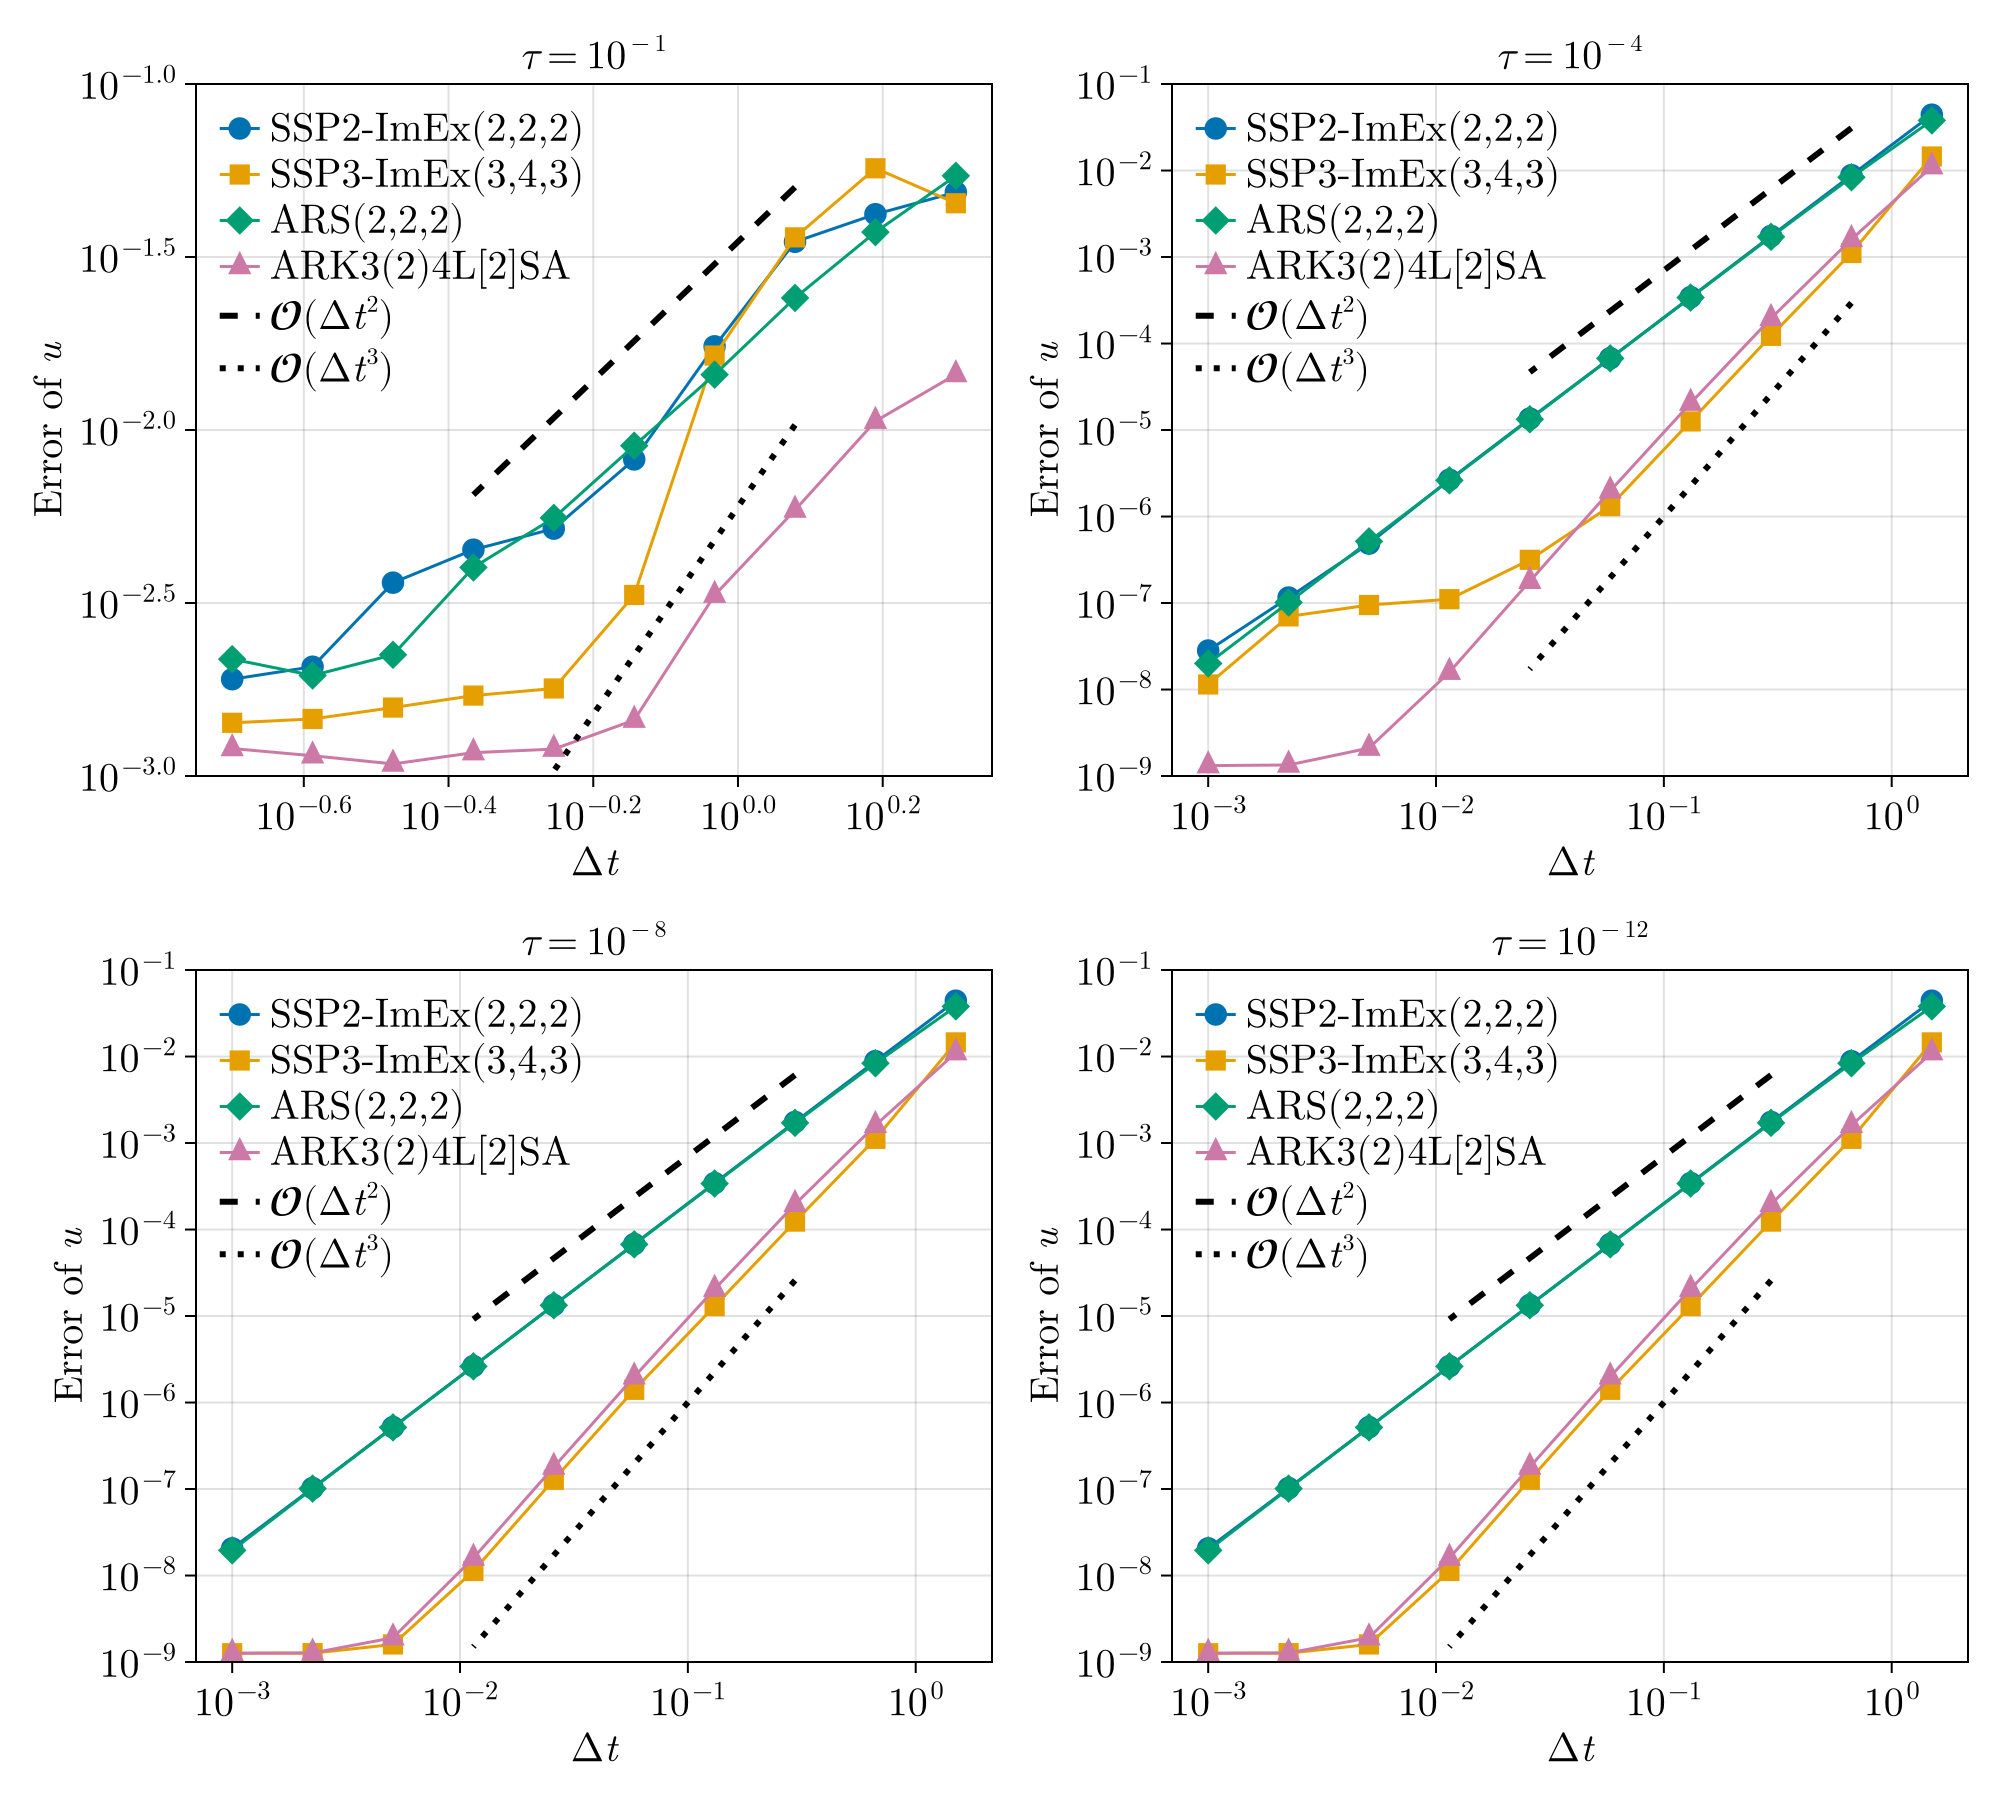

In [41]:
MthdNames = ["SSP2-ImEx(2,2,2)", "SSP3-ImEx(3,4,3)", "ARS(2,2,2)", "ARK3(2)4L[2]SA"]
# Create the dictionary
MthdDict = Dict(zip(Mthds, MthdNames))
markers = [:circle, :rect, :diamond, :utriangle]

# Figure info
yl = [1.0e-3,1.0e-9,1.0e-9,1.0e-9]; yu = [1.0e-1,1.0e-1,1.0e-1,1.0e-1]
P = [2,3]; ST = [3 3; 2 2; 3 3; 3 3]; EN = [7 6; 6 6; 7 7; 7 7]
Fac = [3.5e-2 6.0e-3; 7.0e-2 1.0e-3; 7.0e-2 1.0e-3; 7.0e-2 1.0e-3]

fig_kdvh_AA = Figure(size = (1000, 900))
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for (i, τ) in enumerate(τs)
    dts = DTs[i, :]
    τ_str = τ == 1.0 ? L"\tau = 1" : L"\tau = 10^{-%$(Int(-log10(τ)))}"
    # Create a new axis for each value of τ
    ax = Axis(fig_kdvh_AA[positions[i]...];
              xlabel = L"\Delta t", ylabel = L"Error of $u$", title = τ_str,
              xscale = log10, yscale = log10)

    # Loop over methods and plot the error data for each method
    for (j, alg) in enumerate(Mthds)
        scatterlines!(ax, dts, errors_data[τ][alg]; label = MthdDict[alg], marker = markers[j])
    end

    # Add the reference scaling line after plotting the methods' data
    lines!(ax, dts[ST[i,1]:EN[i,1]], Fac[i,1] * dts[ST[i,1]:EN[i,1]].^(P[1]);
           label = L"\mathcal{O}(\Delta t^{%$(P[1])})", linestyle = :dash)
    lines!(ax, dts[ST[i,2]:EN[i,2]], Fac[i,2] * dts[ST[i,2]:EN[i,2]].^(P[2]);
           label = L"\mathcal{O}(\Delta t^{%$(P[2])})", linestyle = :dot)

    # Show the legend
    axislegend(ax, position = :lt, framevisible = false)
    ylims!(ax, yl[i], yu[i])
end

save(joinpath(save_path_1, "error_convergence_τ_all.pdf"), fig_kdvh_AA)
fig_kdvh_AA

In [22]:
tspan

(0.0, 4.800000000000001)

### Error growth plots for different methods, with and without RK relaxation, applied to $\text{KdVH}(\tau)$, with the exact solution computed using the Petviashvili method.

In [42]:
function kdvh_exact_solitary_wave_error_growth(; domain_traversals = 2,
                                                 τ = 1.0e-2,
                                                 xmin = -40.0,
                                                 xmax = 40.0,
                                                 c = 1.2,
                                                 accuracy_order = 8, N = 2^8,
                                                 alg = ARS443(), dt = 0.01,
                                                 kwargs...)


    # Reference solution by Petviashvili algorithm
    λ = 1/τ; N_ref = 2^10
    x, u0 = petviashvili_kdvh(; xmin = xmin, xmax = xmax, λ = λ, c = c, N = N_ref, maxiter = 1000, tol = 1.0e-12)

    u0itp = LinearInterpolation((x,), u0, extrapolation_bc = Periodic())
    function u_traveling(t, x::Number, equation)
        x_t = mod(x - c * t - xmin, xmax - xmin) + xmin
        u0itp(x_t)
    end
    function u_traveling(t, x::AbstractVector, equation)
        u_traveling.(t, x, equation)
    end


    # Initialization of physical and numerical parameters
    tspan = (0.0, domain_traversals * (xmax - xmin) / c)

    D1 = upwind_operators(periodic_derivative_operator;
       derivative_order = 1, accuracy_order,
       xmin, xmax, N)

    # Setup plot
    fig_err = Figure()
    ax = Axis(fig_err[1, 1]; xlabel = L"t", ylabel = L"Error of $u$",
              xscale = log10, yscale = log10)

    # Setup callback computing the error
    series_t = Vector{Float64}()
    series_error = Vector{Float64}()
    callback = let series_t = series_t, series_error = series_error
        function (q, parameters, t)
            (; tmp, equation) = parameters

            u = get_u(q, equation)
            u_ref = u_traveling(t, grid(parameters.D1), HyperbolizedKdV(τ))

            @. tmp = u - u_ref
            err = integrate(abs2, tmp, parameters.D1) |> sqrt

            push!(series_t, t)
            push!(series_error, err)
            return nothing
        end
    end


    # HyperbolizedKdV with IMEX
    let equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(u_traveling, HyperbolizedKdV(τ), tspan, D1)

        @info "Hyperbolized KdV without relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdVH($τ), baseline")

        @info "Hyperbolized KdV with relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, relaxation = true, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdVH($τ), relaxation")
    end
    n = length(series_t)
    st_ind1 = round(Int, 0.05 * n)
    st_ind2 = round(Int, 0.2 * n)

    println("st_ind1 = ", st_ind1)
    println("st_ind2 = ", st_ind2)

    # Use the start index to slice the array from 20% to the end
    lines!(ax, series_t[st_ind1:100:end], 1e-3 * series_t[st_ind1:100:end];
           label = L"\mathcal{O}(t)", linestyle = :dash)
    lines!(ax, series_t[st_ind1:100:st_ind2], 4e-4 * series_t[st_ind1:100:st_ind2].^ 2;
           label = L"\mathcal{O}(t^2)", linestyle = :dot)

    axislegend(ax, position = :lt, framevisible = false)

    return fig_err
end

kdvh_exact_solitary_wave_error_growth (generic function with 1 method)

┌ Info: Converged
│   iter = 55
└   res = 9.983125437429408e-13
[ Info: Hyperbolized KdV without relaxation


  0.487935 seconds (457.78 k allocations: 50.939 MiB, 2.89% gc time, 35.29% compilation time)


[ Info: Hyperbolized KdV with relaxation


  0.318079 seconds (92.83 k allocations: 27.128 MiB, 1.29% compilation time)
st_ind1 = 336
st_ind2 = 1343


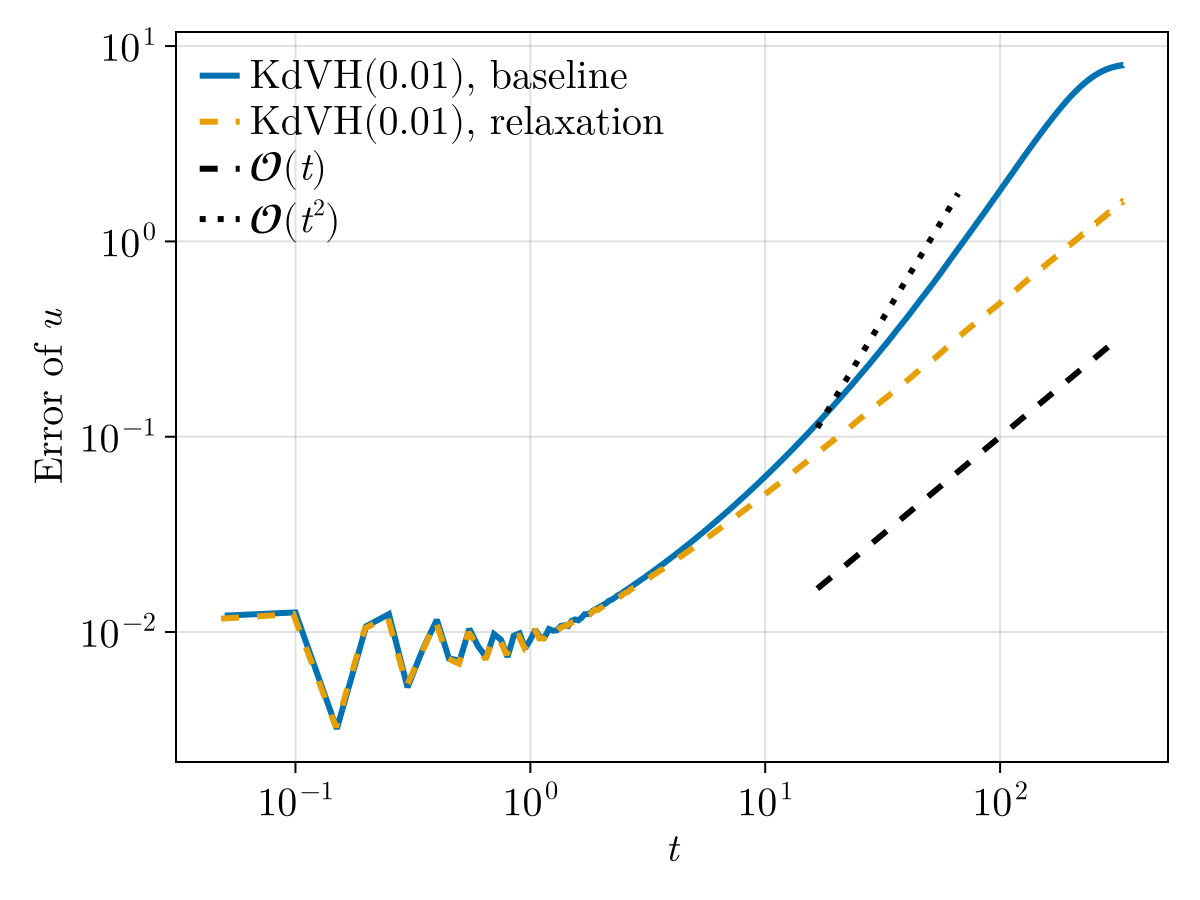

In [43]:
τ = 1.0e-2; xmin = -40.0; xmax = 40.0; c = 1.2; ImEx_name = "SSP2ImEx222"
fig_kdvh_err = kdvh_exact_solitary_wave_error_growth(; domain_traversals = 5,
                                                  τ = τ,
                                                  xmin = xmin,
                                                  xmax = xmax,
                                                  c = c,
                                                  accuracy_order = 8, N = 2^8,
                                                  alg = SSP2ImEx222(), dt = 0.05)

In [44]:
# Saving the file
using Printf
save(joinpath(save_path_1, "KdVH_Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ))_c_$(@sprintf("%.1f", c)).pdf"), fig_kdvh_err)


CairoMakie.Screen{PDF}


┌ Info: Converged
│   iter = 55
└   res = 9.983125437429408e-13
[ Info: Hyperbolized KdV without relaxation


  0.447627 seconds (266.39 k allocations: 38.185 MiB, 26.41% compilation time)


[ Info: Hyperbolized KdV with relaxation


  0.357631 seconds (92.93 k allocations: 29.769 MiB, 3.19% gc time, 1.42% compilation time)
st_ind1 = 336
st_ind2 = 1343


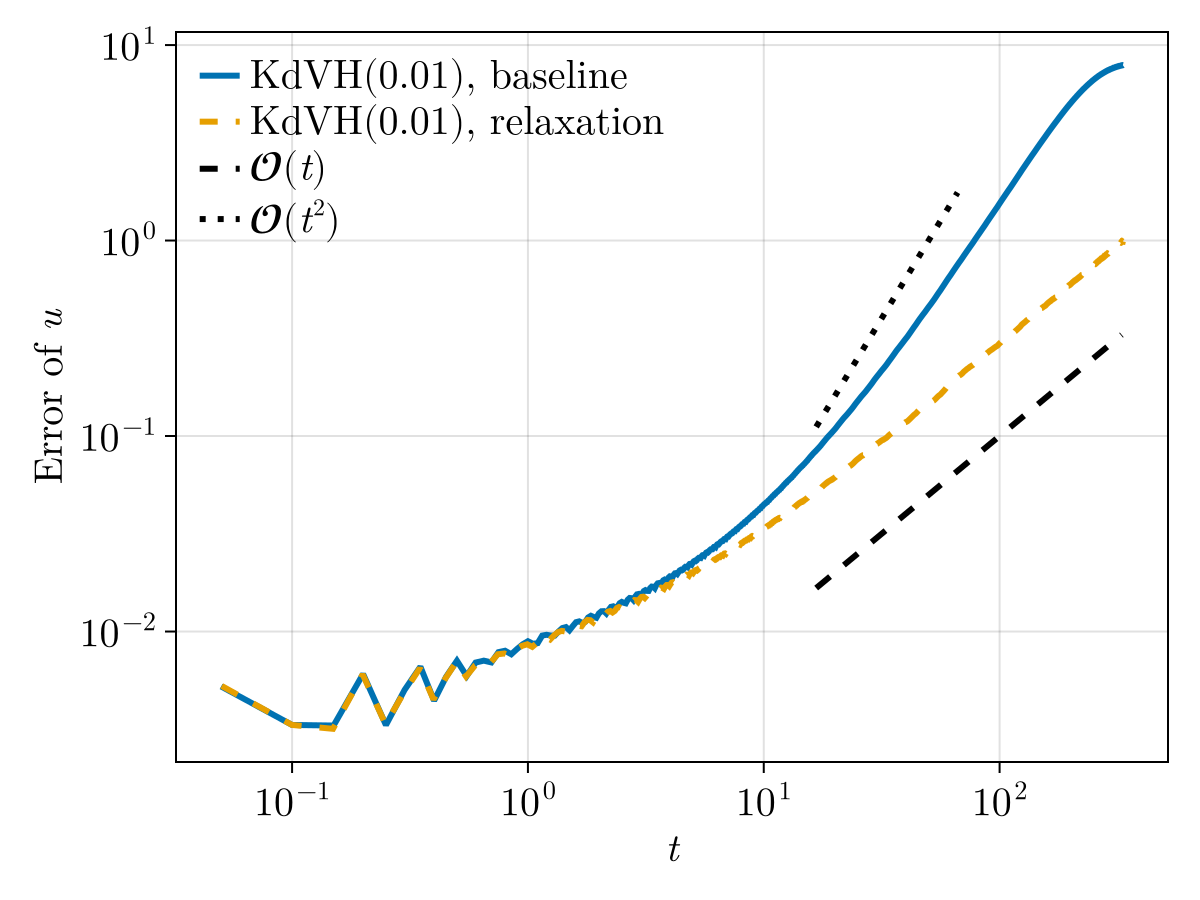

In [45]:
τ = 1.0e-2; xmin = -40.0; xmax = 40.0; c = 1.2; ImEx_name = "ARS222"
fig_kdvh_err = kdvh_exact_solitary_wave_error_growth(; domain_traversals = 5,
                                                  τ = τ,
                                                  xmin = xmin,
                                                  xmax = xmax,
                                                  c = c,
                                                  accuracy_order = 8, N = 2^8,
                                                  alg = ARS222(), dt = 0.05)

In [46]:
# Saving the file
save(joinpath(save_path_1, "KdVH_Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ))_c_$(@sprintf("%.1f", c)).pdf"), fig_kdvh_err)


CairoMakie.Screen{PDF}


### RK relaxation on $\text{KdVH}(\tau)$ to verify linear and quadratic error convergence using conservative versus non-conservative methods.

The error growth of the solutions for the KdV and $\text{KdVH}(\tau)$ systems is analyzed by comparing conservative methods using RK relaxation with non-conservative methods. This approach demonstrates linear error convergence for conservative methods and quadratic error convergence for non-conservative methods. In each case, the numerical solution is compared to the analytical solution of the KdV equation.

In the figure, we will observe:

- Error of the time-stepping method without relaxation for the KdV solution with respect to the KdV analytical solution.
- Error of the time-stepping method with relaxation for the KdV solution with respect to the KdV analytical solution.
- Error of the time-stepping method without relaxation for the KdVH solution (with a particular $\tau$) with respect to the KdV analytical solution.
- Error of the time-stepping method with relaxation for the KdVH solution (with a particular $\tau$) with respect to the KdV analytical solution.

In [28]:
function kdvh_kdv_solitary_wave_error_growth(; τ = 1.0e-4,
                                              domain_traversals = 10,
                                              accuracy_order = 8, N = 2^10,
                                              alg = ARS443(), dt = 0.025,
                                              kwargs...)
    # Initialization of physical and numerical parameters
    (; xmin, xmax, c) = solitary_wave_setup()
    tspan = (0.0, domain_traversals * (xmax - xmin) / c)

    D1 = upwind_operators(periodic_derivative_operator;
                          derivative_order = 1, accuracy_order,
                          xmin, xmax, N)
        # This provides the D3 aw well in case of KdV equation,  I checked.

    # Setup plot
    fig_err = Figure()
    ax = Axis(fig_err[1, 1]; xlabel = L"t", ylabel = L"Error of $u$",
              xscale = log10, yscale = log10)


    # Setup callback computing the error
    series_t = Vector{Float64}()
    series_error = Vector{Float64}()
    callback = let series_t = series_t, series_error = series_error
        function (q, parameters, t)
            (; tmp, equation) = parameters

            u = get_u(q, equation)
            u_ref = solitary_wave_solution(t, grid(parameters.D1), KdV())

            @. tmp = u - u_ref
            err = integrate(abs2, tmp, parameters.D1) |> sqrt

            push!(series_t, t)
            push!(series_error, err)
            return nothing
        end
    end


    # KdV
    let equation = KdV()
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)

        @info "KdV without relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdV, baseline")

        @info "KdV with relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, relaxation = true, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdV, relaxation")
    end


    # HyperbolizedKdV with IMEX
    let equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)

        @info "Hyperbolized KdV without relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdVH, baseline")

        @info "Hyperbolized KdV with relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, relaxation = true, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdVH, relaxation")
    end

    # Use the start index to slice the array from 20% to the end
    n = length(series_t)
    st_ind1 = round(Int, 0.05 * n)
    st_ind2 = round(Int, 0.2 * n)
    lines!(ax, series_t[st_ind1:100:end], 1e-3 * series_t[st_ind1:100:end];
           label = L"\mathcal{O}(t)", linestyle = :dash)
    lines!(ax, series_t[st_ind1:100:st_ind2], 4e-4 * series_t[st_ind1:100:st_ind2].^ 2;
           label = L"\mathcal{O}(t^2)", linestyle = :dot)

    axislegend(ax, position = :lt, framevisible = false)

    return fig_err
end

kdvh_kdv_solitary_wave_error_growth (generic function with 1 method)

[ Info: KdV without relaxation


  0.558672 seconds (220.43 k allocations: 30.187 MiB, 22.12% compilation time)


[ Info: KdV with relaxation


  0.433638 seconds (34.50 k allocations: 18.067 MiB, 0.82% compilation time)


[ Info: Hyperbolized KdV without relaxation


  0.912835 seconds (298.33 k allocations: 40.871 MiB, 20.71% gc time, 34.88% compilation time)


[ Info: Hyperbolized KdV with relaxation


  0.592580 seconds (38.60 k allocations: 23.948 MiB, 0.62% compilation time)


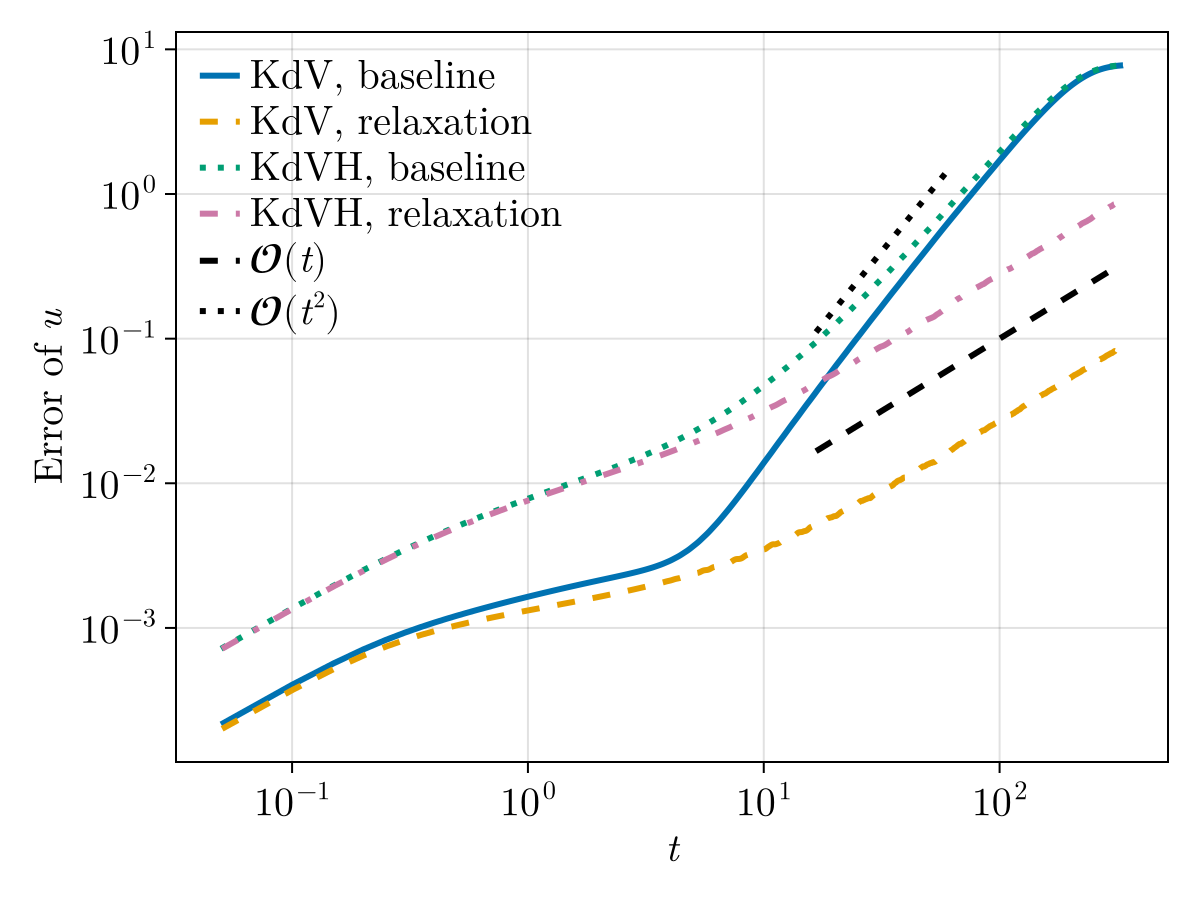

In [29]:
τ = 1.0e-3; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [30]:
# Saving the file
save(joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ)).pdf"), fig_err)


CairoMakie.Screen{PDF}


[ Info: KdV without relaxation


  0.435194 seconds (33.66 k allocations: 18.367 MiB)


[ Info: KdV with relaxation


  0.432807 seconds (33.32 k allocations: 17.984 MiB)


[ Info: Hyperbolized KdV without relaxation


  0.601823 seconds (37.76 k allocations: 25.142 MiB, 0.83% gc time)


[ Info: Hyperbolized KdV with relaxation


  0.588916 seconds (37.43 k allocations: 24.997 MiB)


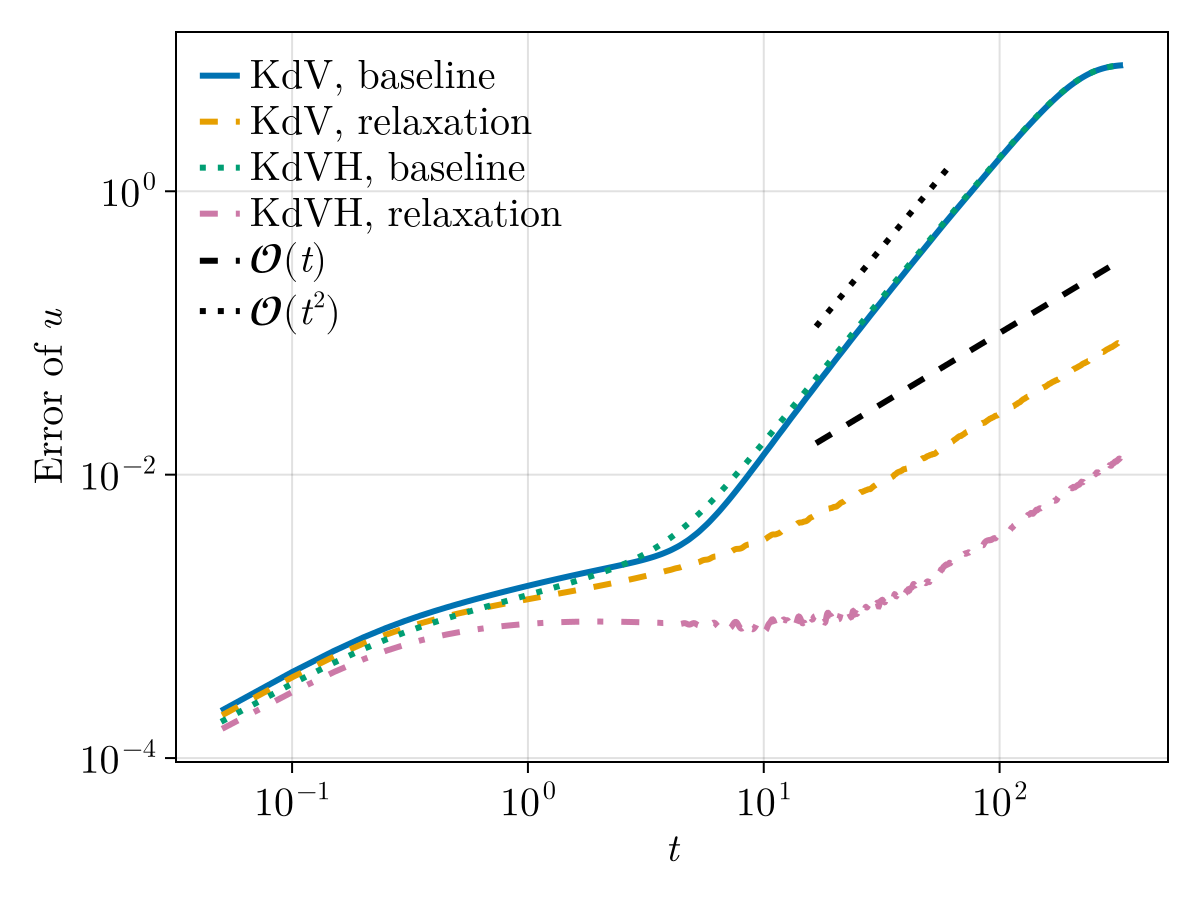

In [31]:
τ = 1.0e-4; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [32]:
# Saving the file
save(joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ)).pdf"), fig_err)


CairoMakie.Screen{PDF}


[ Info: KdV without relaxation


  0.436986 seconds (33.66 k allocations: 18.367 MiB)


[ Info: KdV with relaxation


  0.432321 seconds (33.32 k allocations: 17.984 MiB)


[ Info: Hyperbolized KdV without relaxation


  1.226283 seconds (37.75 k allocations: 27.407 MiB)


[ Info: Hyperbolized KdV with relaxation


  1.214671 seconds (37.45 k allocations: 26.129 MiB, 0.42% gc time)


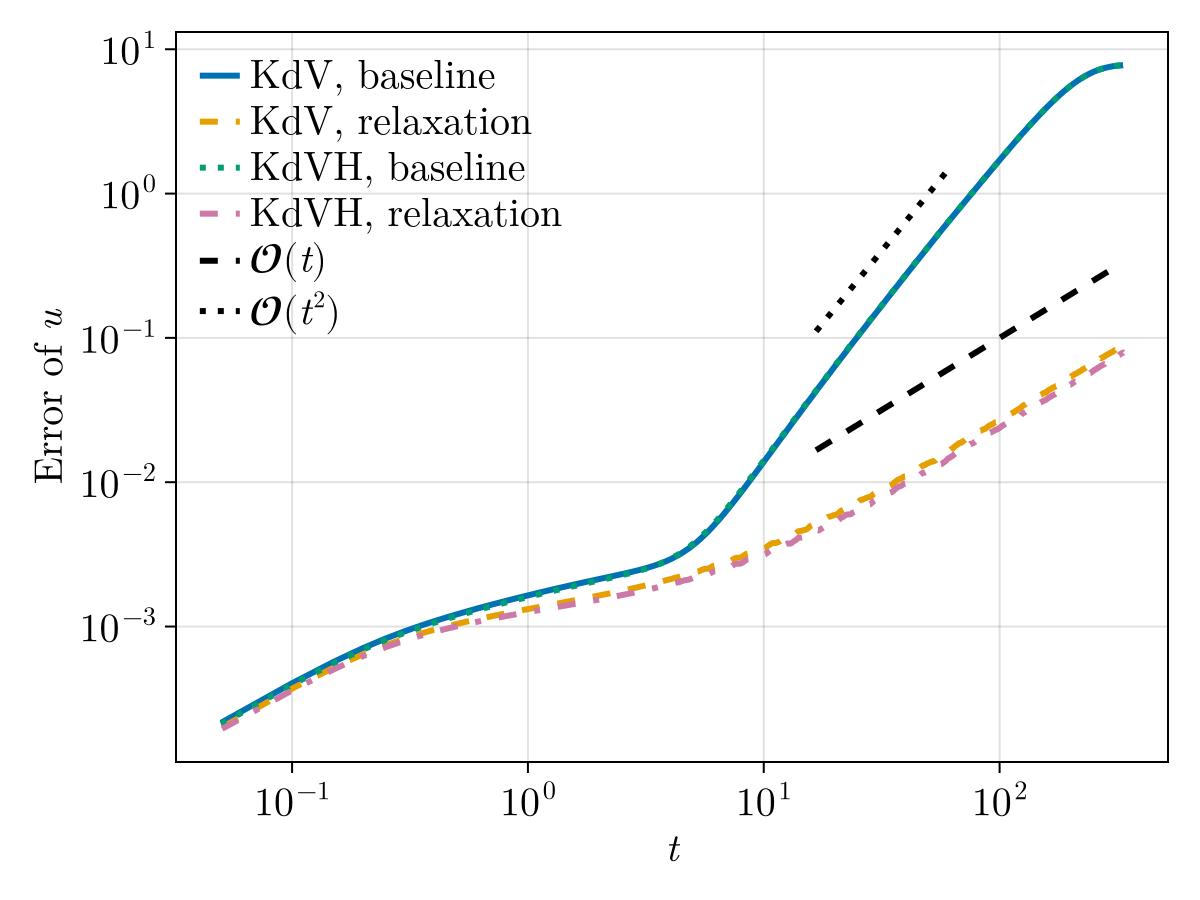

In [33]:
τ = 1.0e-5; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [34]:
# Saving the file
save(joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ)).pdf"), fig_err)


CairoMakie.Screen{PDF}


[ Info: KdV without relaxation


  0.441618 seconds (33.66 k allocations: 18.367 MiB, 0.93% gc time)


[ Info: KdV with relaxation


  0.431743 seconds (33.32 k allocations: 17.984 MiB)


[ Info: Hyperbolized KdV without relaxation


  1.211155 seconds (37.75 k allocations: 27.409 MiB)


[ Info: Hyperbolized KdV with relaxation


  1.198227 seconds (37.43 k allocations: 27.263 MiB)


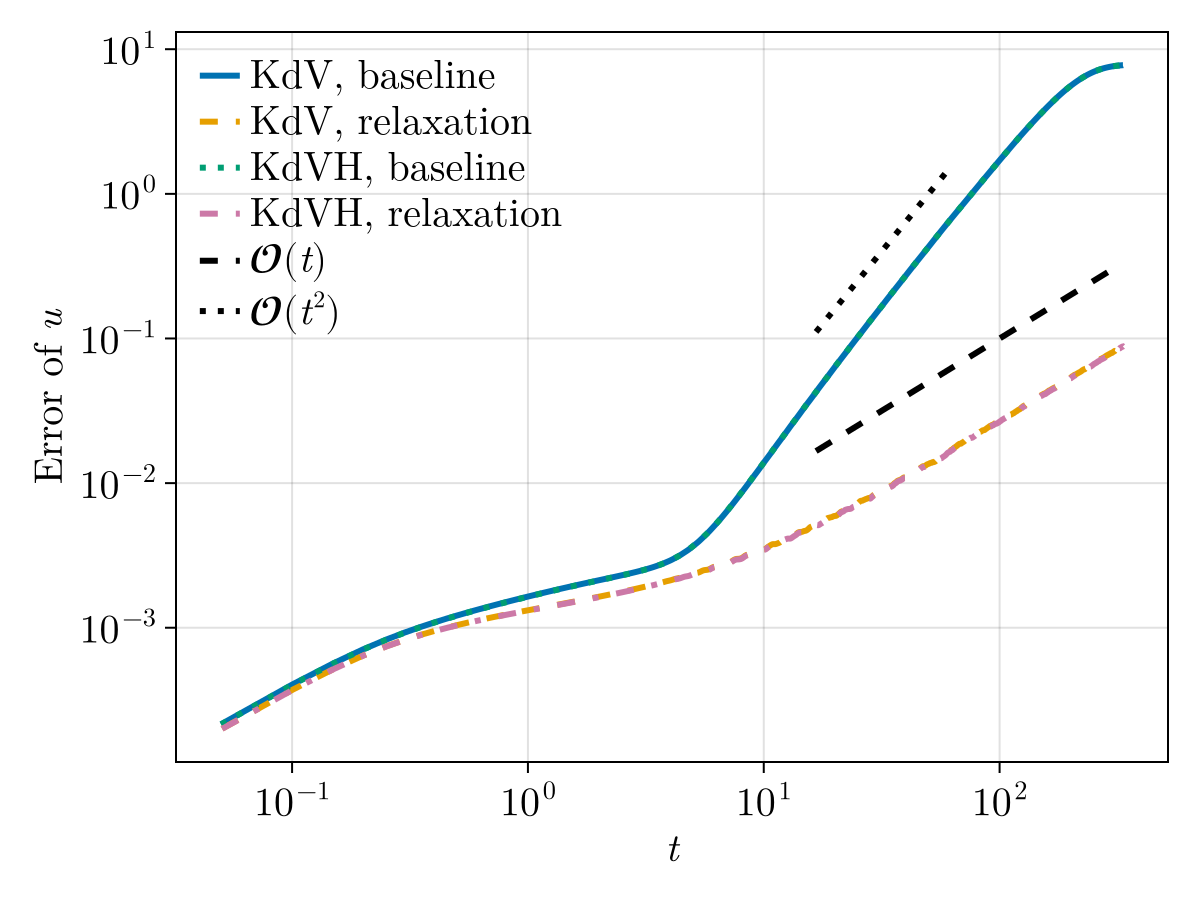

In [35]:
τ = 1.0e-6; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [36]:
# Saving the file
save(joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ)).pdf"), fig_err)


CairoMakie.Screen{PDF}


#### Experiment with fourier_derivative_operator

  4.156329 seconds (3.84 k allocations: 568.677 MiB, 6.09% gc time)


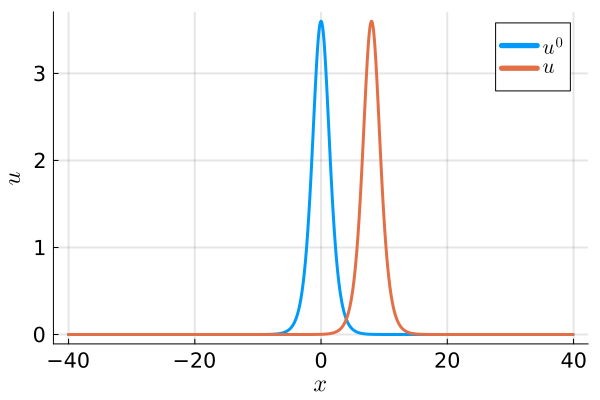

In [51]:
hyperbolized_kdv_test(; τ = 1.0e-4,
semidiscretization = fourier_derivative_operator,
N = 2^10,
domain_traversals = 0.1,
accuracy_order = 4,
alg = ARS222(),
dt = 0.01)

In [83]:
AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = fourier_derivative_operator,
                   N = 2^6,
                   alg = AGSA342(),
                   ImEx_name = "AGSA342",
                   dt = 0.00005)

  2.320270 seconds (2.67 M allocations: 61.370 MiB)
 12.926289 seconds (2.67 M allocations: 64.433 MiB, 0.07% gc time)
 72.505336 seconds (2.67 M allocations: 64.432 MiB)
 12.761764 seconds (2.67 M allocations: 64.432 MiB, 0.09% gc time)
 12.806108 seconds (2.67 M allocations: 64.432 MiB)
 12.850249 seconds (2.67 M allocations: 64.432 MiB, 0.05% gc time)
 12.722377 seconds (2.67 M allocations: 64.432 MiB)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.69e+00 │   NaN │ 3.06e+00 │   NaN │ 3.55e+00 │   NaN │
│ 1.00e-03 │ 8.73e-02 │  0.81 │ 1.24e-01 │  0.70 │ 2.05e-01 │  0.62 │
│ 1.00e-05 │ 1.21e-03 │  0.93 │ 2.35e-03 │  0.86 │ 5.20e-03 │  0.80 │
│ 1.00e-07 │ 1.21e-05 │  1.00 │ 2.35e-05 │  1.00 │ 5.20e-05 │  1.00 │
│ 1.00e-09 │ 1.21e-07 │  1.00 │ 2.35e-07 │  1.00 │ 5.20e-07 │  1.00 │
│ 1.00e-11 │ 1.21e-09 │  1.00 │

[ Info: Errors with respect to the numerical KdV solution


In [84]:
AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^6,
                   alg = AGSA342(),
                   ImEx_name = "AGSA342",
                   dt = 0.00005)

  4.115941 seconds (1.33 M allocations: 22.054 MiB)
  6.980181 seconds (1.33 M allocations: 23.762 MiB, 0.09% gc time)
  6.940377 seconds (1.33 M allocations: 23.762 MiB)
  6.962050 seconds (1.33 M allocations: 23.762 MiB)
  7.324407 seconds (1.33 M allocations: 23.727 MiB)
  8.996643 seconds (1.33 M allocations: 24.880 MiB)
  8.979189 seconds (1.33 M allocations: 25.075 MiB)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.70e+00 │   NaN │ 3.14e+00 │   NaN │ 3.49e+00 │   NaN │
│ 1.00e-03 │ 9.34e-02 │  0.80 │ 1.37e-01 │  0.68 │ 1.99e-01 │  0.62 │
│ 1.00e-05 │ 9.57e-04 │  0.99 │ 1.42e-03 │  0.99 │ 2.08e-03 │  0.99 │
│ 1.00e-07 │ 9.58e-06 │  1.00 │ 1.42e-05 │  1.00 │ 2.08e-05 │  1.00 │
│ 1.00e-09 │ 9.58e-08 │  1.00 │ 1.42e-07 │  1.00 │ 2.09e-07 │  1.00 │
│ 1.00e-11 │ 9.58e-10 │  1.00 │ 3.13e-08 │  0.33 │ 3.21e-07 │

[ Info: Errors with respect to the numerical KdV solution
